# **Load Dependencies**


In [ ]:
# Basic libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

import os
import mlflow
import mlflow.keras  # For logging Keras models
import mlflow.sklearn  # For logging Scikit-learn models

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use("ggplot")

# Libraries for text processing and NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("stopwords")


# Machine Learning libraries for feature extraction, data splitting, and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Deep Learning libraries for model building, tokenization, and padding
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import BinaryCrossentropy
# Warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Importing DataSet & Preprocessing**

In [2]:
df=pd.read_csv("IMDB Dataset.csv")
df.sample(5)

,review,sentiment
45268,Those prophetic words were spoken by William H...,positive
45299,Mark Blankfield played Jekyll and Hyde.<br /><...,positive
34538,It's dreadful rubbish. I liked 'How Do You Wan...,negative
16174,If I had to decide which was the best Ernest m...,positive
4847,The Merchant of Venice is a fantastic movie. I...,positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
print('Number Of Duplications is : ' ,{df.duplicated().sum()})
df.drop_duplicates(inplace=True)
print('\nNumber Of Duplications is : ' ,{df.duplicated().sum()})

Number Of Duplications is :  {418}

Number Of Duplications is :  {0}


In [9]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [4]:
df.loc[df['sentiment']=='positive','sentiment']=1
df.loc[df['sentiment']=='negative','sentiment']=0

In [11]:
df['sentiment'].unique()

array([1, 0], dtype=object)

In [13]:
df['review'][840]

"A Brother's Promise is a wonderful family film. This is a biography of Dan Jansen, a champion Olympic speed skater. The movie depicts this athlete's life from a young age through full adulthood. The love and support of the family members is evident throughout. How Dan and the rest of his family handle winning and losing races is a life lesson for all of us. The commitment and determination of Dan's coach and his teammates, shows what it takes to make a real team. How Dan and his family deal with a devastating illness of a loved one is depicted without undo sentiment or sugarcoating. The faith of the family is shown in basic terms and is obviously a major part of their lives. This is a powerful family film which can be meaningful for a person of any age."

In [5]:
stop_words = set(stopwords.words("english"))

tag_pattern = re.compile(r'<[^>]+>')

def remove_tags(text):
    return tag_pattern.sub('', text)

def preprocess_text(sen):
    # Removing HTML tags
    sentence = remove_tags(sen)
    
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Remove punctuation and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Remove single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove stop words
    sentence = ' '.join([word for word in sentence.split() if word not in stop_words])

    return sentence


In [ ]:
# Apply the preprocess_text function to each review in the 'review' column to clean and transform the text data
df['review'] = df['review'].apply(preprocess_text)


In [7]:
df['review'][840]

'brother promise wonderful family film biography dan jansen champion olympic speed skater movie depicts athlete life young age full adulthood love support family members evident throughout dan rest family handle winning losing races life lesson us commitment determination dan coach teammates shows takes make real team dan family deal devastating illness loved one depicted without undo sentiment sugarcoating faith family shown basic terms obviously major part lives powerful family film meaningful person age'

In [8]:
df.sample(10)

,review,sentiment
9823,avoid usa version added us footage worst dubbi...,0
30186,seen tired worn clich sit com stories characte...,0
29842,step fair dance film kids get big performance ...,0
2514,defining scene movie fat guy quits evil doctor...,0
37514,fertile man ireland revolves around eamon manl...,0
16683,flock unjustly maligned lesser se en ripoff re...,1
38831,interesting aspect apprentice demonstrates tra...,1
47018,true one really expects anything sequels even ...,0
26154,another comedy plucky little country strugglin...,1
21163,honestly surprised alone dark bad could hardly...,0


In [9]:
# Create a new column 'word_length' that contains the number of words in each preprocessed tweet
df['word_length'] = df['review'].apply(lambda x: len(x.split(" ")))

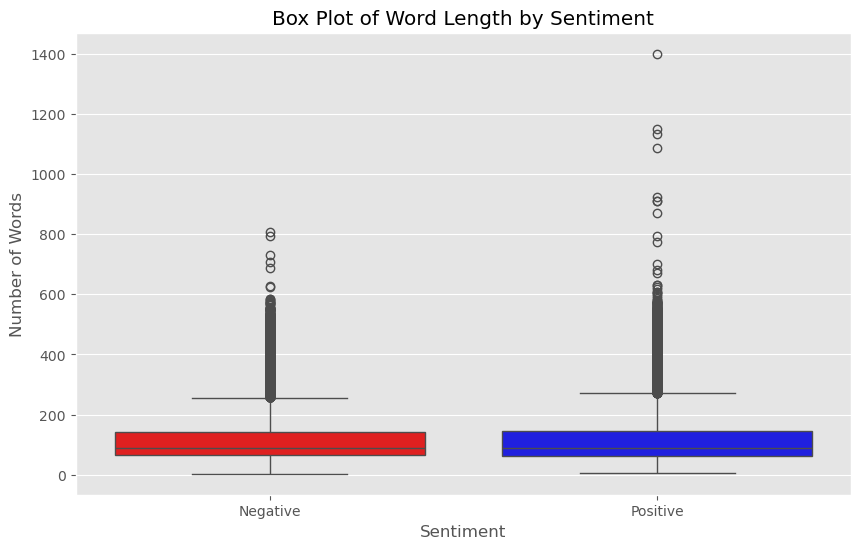

In [10]:
# Set up the plot size
plt.figure(figsize=(10, 6))

# Create a box plot for word length distribution by sentiment
sns.boxplot(x='sentiment', y='word_length', data=df, palette=['red', 'blue'])

# Update plot aesthetics
plt.title("Box Plot of Word Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.xticks([0, 1], ['Negative', 'Positive'])  # Label x-axis for sentiment categories
plt.show()


# **Split Data & Tokenization**

In [ ]:
# spit data into train and test data
X=df['review']
y=df['sentiment']
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.20, random_state=42)


#Tokenizer create a word-to-index dictionary. In the word-to-index dictionary, each word is used as a key, while a corresponding unique index is used as the value for the key

# Create a word-to-index dictionary using the Tokenizer, mapping each word to a unique index
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary to the top 5000 words
tokenizer.fit_on_texts(X)  # Fit the tokenizer on the text data

max_len = 100  # Define the maximum length of input sequences
word_index = tokenizer.word_index  # Get the word-to-index dictionary

# Convert the training and test texts to sequences of integers based on the word index
X_train_seq = tokenizer.texts_to_sequences(X_train)  # Convert training texts to sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convert test texts to sequences

# Pad the sequences to ensure uniform input size for the model
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')  # Pad training sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')  # Pad test sequences

# Define vocabulary size (number of unique words + 1 for padding)
vocab_size = len(tokenizer.word_index) + 1  # Calculate vocabulary size


In [21]:
# Load GloVe embeddings
embeddings_dictionary = {}
with open('glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
# Create embedding matrix
embedding_dim = 100  # Using 100-dimensional GloVe embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [12]:
y_train = np.array(y_train, dtype='float32')  # Ensure labels are float for binary classification
y_test=np.array(y_test, dtype='float32')

# `LSTM Experiment`

Dataset logged at: IMDB Dataset.csv/IMDB Dataset.csv
Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 66s 257ms/step - accuracy: 0.5975 - loss: 0.6463 - val_accuracy: 0.7961 - val_loss: 0.4683
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 72s 290ms/step - accuracy: 0.8135 - loss: 0.4314 - val_accuracy: 0.8270 - val_loss: 0.3948
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 72s 291ms/step - accuracy: 0.8345 - loss: 0.3814 - val_accuracy: 0.8359 - val_loss: 0.3716
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 72s 289ms/step - accuracy: 0.8474 - loss: 0.3527 - val_accuracy: 0.8428 - val_loss: 0.3581
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 71s 288ms/step - accuracy: 0.8644 - loss: 0.3174 - val_accuracy: 0.8560 - val_loss: 0.3418
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 73s 295ms/step - accuracy: 0.8719 - loss: 0.3048 - val_accuracy: 0.8603 - val_loss: 0.3314
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 57s 231ms/step - accuracy: 0.8803 - loss: 0.2924 - val_accuracy: 0.8664 - val_loss: 0.3255
Epoch 8/10
248/248 ━━━━━━━━━━━

Epoch 9/10 - Train Accuracy: 0.8904, Validation Accuracy: 0.8667
Epoch 10/10 - Train Accuracy: 0.9007, Validation Accuracy: 0.8678


310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
Run complete. Check MLflow UI for details.


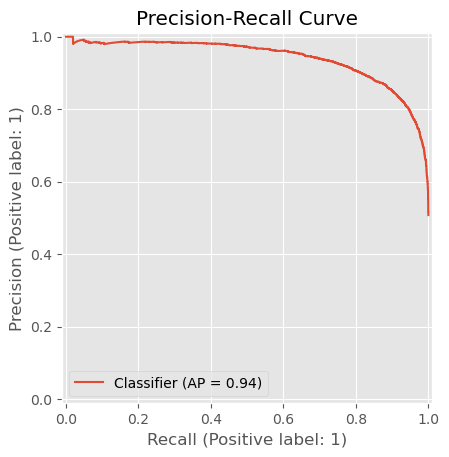

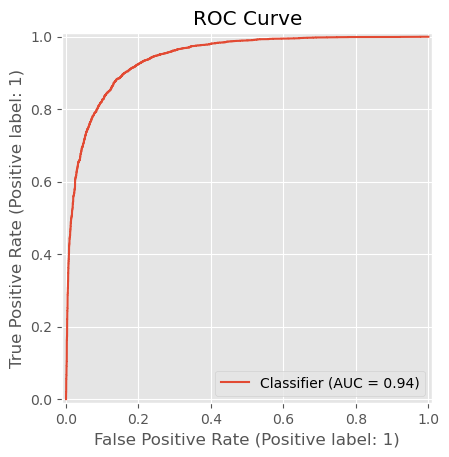

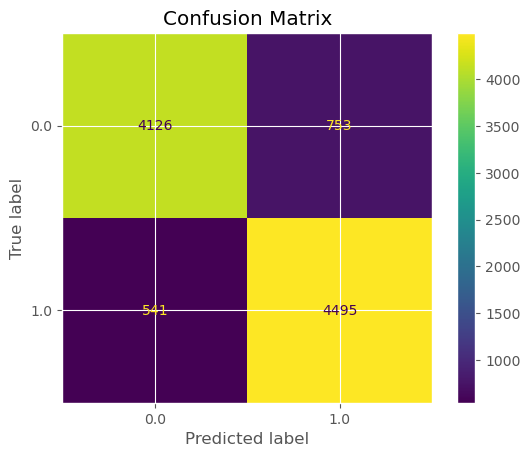

In [ ]:
# Set hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 128

# Define LSTM model function
def lstm_model(input_length):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=input_length, trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Set the MLflow experiment
mlflow.set_experiment("LSTM_MODEL_exp")

# Create the metrics directory if it doesn't exist
os.makedirs("metrics", exist_ok=True)

# Start an MLflow run
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    # Save the dataset locally before logging it 
    dataset_path = "IMDB Dataset.csv/IMDB Dataset.csv"
    df.to_csv(dataset_path, index=False)

    # Log the dataset as an artifact
    mlflow.log_artifact(dataset_path, artifact_path="datasets")

    # Log other parameters
    mlflow.log_param("data_source", "IMDB_DataSet")
    print(f'Dataset logged at: {dataset_path}')

    # Create and compile the model
    model = lstm_model(input_length=max_len)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

    # Log metrics for each epoch
    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

        print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {history.history['accuracy'][epoch]:.4f}, Validation Accuracy: {history.history['val_accuracy'][epoch]:.4f}")

    # Save the model as an artifact
    model_filename = "lstm_imdb_model.h5"
    model.save(model_filename)
    mlflow.log_artifact(model_filename)

    # Log model summary, dataset details, and code structure to a text file
    with open("model_summary.txt", "w") as f:
        # Write dataset summary
        f.write("Dataset Summary:\n")
        f.write(f"Number of training samples: {len(X_train_pad)}\n")
        f.write(f"Input sequence length: {max_len}\n")
        f.write(f"Vocabulary size: {vocab_size}\n\n")

        # Write code structure summary
        f.write("Code Structure Summary:\n")
        f.write("1. Defined LSTM model with an embedding layer and one LSTM layer.\n")
        f.write("2. Model is compiled with Adam optimizer and binary crossentropy loss.\n")
        f.write("3. Trained the model over multiple epochs and logged metrics with MLflow.\n\n")

        # Write model summary
        f.write("Model Summary:\n")
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    # Log the text file as an artifact
    mlflow.log_artifact("model_summary.txt")

    # Make predictions
    y_pred_probs = model.predict(X_test_pad)
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Log Precision-Recall Curve
    fig_pr = plt.figure()
    pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_probs)
    plt.title("Precision-Recall Curve")
    plt.savefig("metrics/precision_recall_curve.png")
    mlflow.log_artifact("metrics/precision_recall_curve.png")
    plt.close(fig_pr)

    # Log ROC Curve
    fig_roc = plt.figure()
    roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_probs)
    plt.title("ROC Curve")
    plt.savefig("metrics/roc_curve.png")
    mlflow.log_artifact("metrics/roc_curve.png")
    plt.close(fig_roc)

    # Log Confusion Matrix
    fig_cm = plt.figure()
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Confusion Matrix")
    plt.savefig("metrics/confusion_matrix.png")
    mlflow.log_artifact("metrics/confusion_matrix.png")
    plt.close(fig_cm)

    print("Run complete. Check MLflow UI for details.")


# `Logistic Regression Experiment`

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer()

# Fit the TF-IDF model on the entire dataset (X) to learn the vocabulary and IDF values
tfidf.fit(X)

# Transform the training texts into TF-IDF feature vectors
X_train_tfidf = tfidf.transform(X_train)

# Transform the test texts into TF-IDF feature vectors
X_test_tfidf = tfidf.transform(X_test)


Logistic Regression Model

Dataset logged at :IMDB Dataset.csv\IMDB Dataset.csv


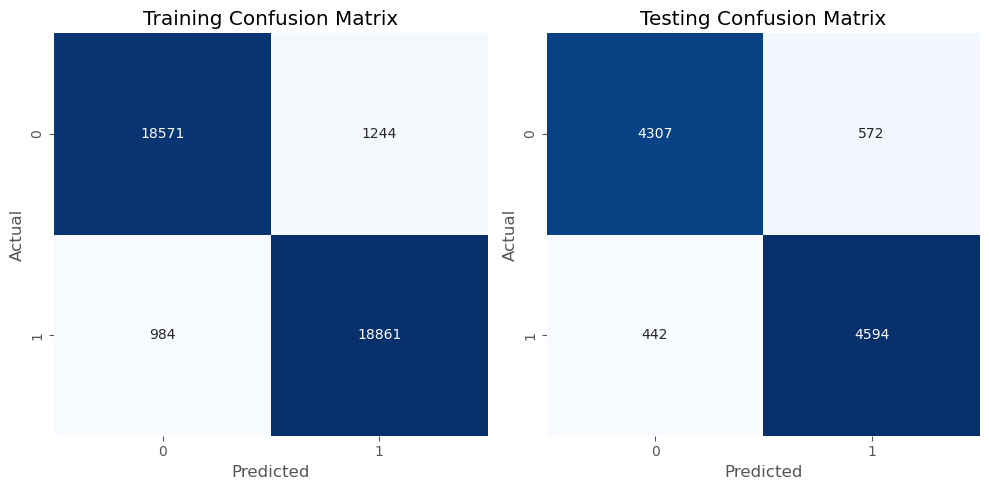

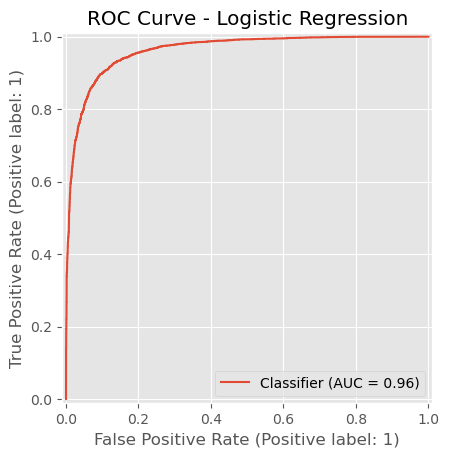

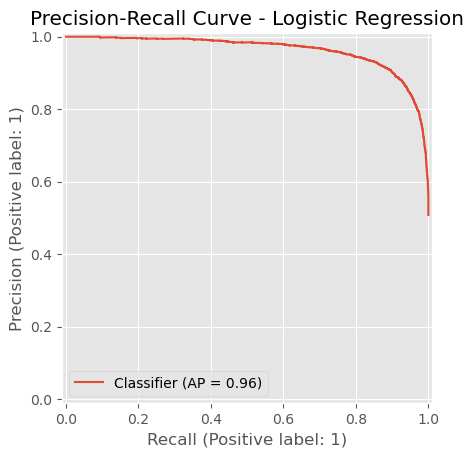

Logistic Regression Training Performance

Train Accuracy = 0.9438
F1 Score = 0.9006
AUC = 0.9624

Logistic Regression Testing Performance

Test Accuracy = 0.8977
Test Report = 
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89      4879
         1.0       0.89      0.91      0.90      5036

    accuracy                           0.90      9915
   macro avg       0.90      0.90      0.90      9915
weighted avg       0.90      0.90      0.90      9915

Test Confusion Matrix = 
[[4307  572]
 [ 442 4594]]


In [ ]:
# Ensure the metrics directory exists
os.makedirs("metrics", exist_ok=True)

def evaluate_model(y_true, y_pred):
    # Calculate confusion matrix and accuracy
    cm = confusion_matrix(y_true, y_pred)
    accuracy = (y_true == y_pred).mean()
    report = classification_report(y_true, y_pred)
    return report, cm, accuracy

# Logistic Regression Model Evaluation
def evaluate_logistic_regression(X_train, X_test, y_train, y_test, max_iter=200, C=1.5, solver='lbfgs'):
    # Set the experiment name in MLflow
    mlflow.set_experiment("Logistic_Regression_Experiment")

    model = LogisticRegression(max_iter=max_iter, solver=solver, C=C)
    print("Logistic Regression Model\n")

    # Start an MLflow run for Logistic Regression
    with mlflow.start_run(run_name="Logistic_Regression"):
        mlflow.log_param("solver", solver)
        mlflow.log_param("C", C)
        mlflow.log_param("max_iter", max_iter)

        #save the dataset locally before logging it 
        dataset_path="IMDB Dataset.csv\IMDB Dataset.csv"
        df.to_csv(dataset_path,index=False)
        # log  other parameters 
        mlflow.log_param("data_source","IMDB_DataSet")
        print(f'Dataset logged at :{dataset_path}')
        
        # Fit the model on training data
        model.fit(X_train, y_train)

        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC

        # Evaluate the model
        train_report, train_cm, train_accuracy = evaluate_model(y_train, train_pred)
        test_report, test_cm, test_accuracy = evaluate_model(y_test, test_pred)
        f1 = f1_score(y_test, test_pred)  # Calculate F1 score
        auc = roc_auc_score(y_test, test_pred_proba)  # Calculate AUC score

        # Log metrics
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("f1_score", f1)  # Log F1 score
        mlflow.log_metric("auc", auc)  # Log AUC score
        mlflow.log_text(str(train_report), "train_classification_report.txt")
        mlflow.log_text(str(test_report), "test_classification_report.txt")

        # Save the model as an artifact
        model_filename = "logistic_regression_model3.pkl"
        mlflow.sklearn.save_model(model, model_filename)  # Log the model
        mlflow.log_artifact(model_filename)

        # Plot and log confusion matrix
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Training Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Testing Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig("metrics/confusion_matrix_logistic_regression.png")
        mlflow.log_artifact("metrics/confusion_matrix_logistic_regression.png")
        plt.show()  # Display the confusion matrix plot
        plt.close()  # Close the figure

        # Log ROC Curve
        fig_roc = plt.figure()
        RocCurveDisplay.from_predictions(y_test, test_pred_proba, ax=plt.gca())
        plt.title("ROC Curve - Logistic Regression")
        plt.savefig("metrics/roc_curve_logistic_regression.png")
        mlflow.log_artifact("metrics/roc_curve_logistic_regression.png")
        plt.show()  # Display the ROC curve plot
        plt.close()  # Close the figure

        # Log Precision-Recall Curve
        fig_pr = plt.figure()
        PrecisionRecallDisplay.from_predictions(y_test, test_pred_proba, ax=plt.gca())  # Use probabilities
        plt.title("Precision-Recall Curve - Logistic Regression")
        plt.savefig("metrics/precision_recall_curve_logistic_regression.png")
        mlflow.log_artifact("metrics/precision_recall_curve_logistic_regression.png")
        plt.show()  # Display the precision-recall curve plot
        plt.close()  # Close the figure

        # Print results
        print('Logistic Regression Training Performance\n')
        print(f"Train Accuracy = {train_accuracy:.4f}")
        print(f"F1 Score = {f1:.4f}")
        print(f"AUC = {auc:.4f}")
        print('\nLogistic Regression Testing Performance\n')
        print(f"Test Accuracy = {test_accuracy:.4f}")
        print(f"Test Report = \n{test_report}")
        print(f"Test Confusion Matrix = \n{test_cm}")

# Execute the evaluation
evaluate_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test)


# `Random Forest Experiment`

Random Forest Model



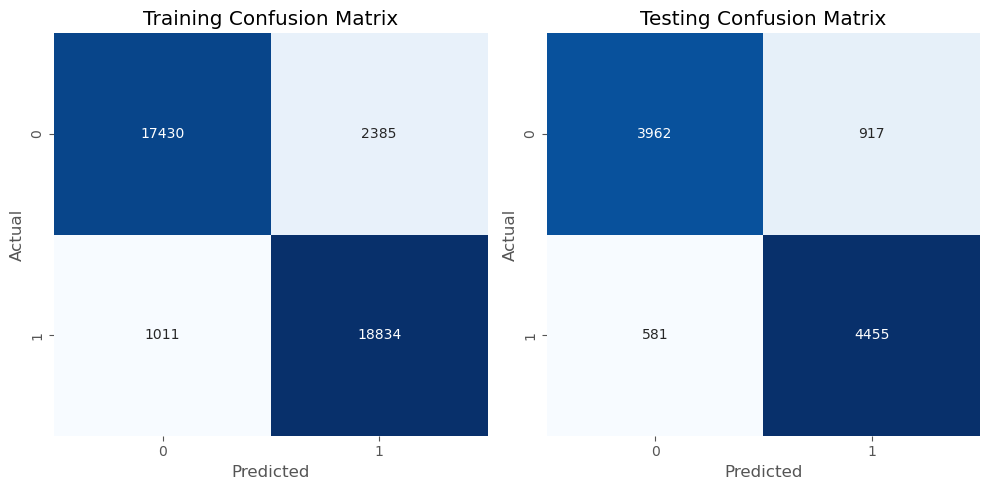

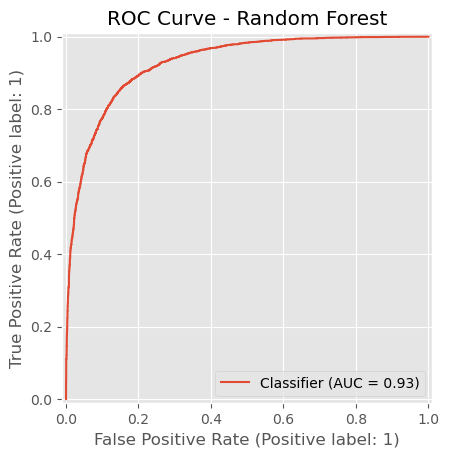

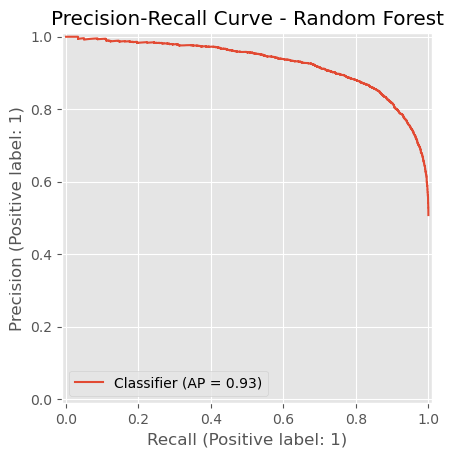

Random Forest Training Performance

Train Accuracy = 0.9144
F1 Score = 0.8561
AUC = 0.9276

Random Forest Testing Performance

Test Accuracy = 0.8489
Test Report = 
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84      4879
         1.0       0.83      0.88      0.86      5036

    accuracy                           0.85      9915
   macro avg       0.85      0.85      0.85      9915
weighted avg       0.85      0.85      0.85      9915

Test Confusion Matrix = 
[[3962  917]
 [ 581 4455]]


In [ ]:
def evaluate_random_forest(X_train, X_test, y_train, y_test, n_estimators=200, criterion='gini', max_depth=18):
    # Set the experiment name 
    mlflow.set_experiment("Random_Forest_Experiment")

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion= criterion)
    print("Random Forest Model\n")

    with mlflow.start_run(run_name="Random_Forest"):
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("criterion", criterion)
        # Fit the model on training data
        model.fit(X_train, y_train)
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        test_pred_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for AUC

        # Evaluate the model
        train_report, train_cm, train_accuracy = evaluate_model(y_train, train_pred)
        test_report, test_cm, test_accuracy = evaluate_model(y_test, test_pred)
        f1 = f1_score(y_test, test_pred)  # Calculate F1 score
        auc = roc_auc_score(y_test, test_pred_proba)  # Calculate AUC score

        # Log metrics
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("f1_score", f1)  # Log F1 score
        mlflow.log_metric("auc", auc)  # Log AUC score
        mlflow.log_text(str(train_report), "train_classification_report.txt")
        mlflow.log_text(str(test_report), "test_classification_report.txt")

        # Save the model as an artifact
        model_filename = "random_forest_model.pkl"
        mlflow.sklearn.save_model(model, model_filename)  # Log the model
        mlflow.log_artifact(model_filename)

        # Plot and log confusion matrix
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Training Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Testing Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig("metrics/confusion_matrix_random_forest.png")
        mlflow.log_artifact("metrics/confusion_matrix_random_forest.png")
        plt.show()
        plt.close()

        # Log ROC Curve
        fig_roc = plt.figure()
        RocCurveDisplay.from_predictions(y_test, test_pred_proba, ax=plt.gca())
        plt.title("ROC Curve - Random Forest")
        plt.savefig("metrics/roc_curve_random_forest.png")
        mlflow.log_artifact("metrics/roc_curve_random_forest.png")
        plt.show()
        plt.close()

        # Log Precision-Recall Curve
        fig_pr = plt.figure()
        PrecisionRecallDisplay.from_predictions(y_test, test_pred_proba, ax=plt.gca())
        plt.title("Precision-Recall Curve - Random Forest")
        plt.savefig("metrics/precision_recall_curve_random_forest.png")
        mlflow.log_artifact("metrics/precision_recall_curve_random_forest.png")
        plt.show()
        plt.close()

        # Print results
        print('Random Forest Training Performance\n')
        print(f"Train Accuracy = {train_accuracy:.4f}")
        print(f"F1 Score = {f1:.4f}")
        print(f"AUC = {auc:.4f}")
        print('\nRandom Forest Testing Performance\n')
        print(f"Test Accuracy = {test_accuracy:.4f}")
        print(f"Test Report = \n{test_report}")
        print(f"Test Confusion Matrix = \n{test_cm}")

# Execute the evaluation
evaluate_random_forest(X_train_tfidf, X_test_tfidf, y_train, y_test)


# `XGBOOST Experiment`

XGBoost Model



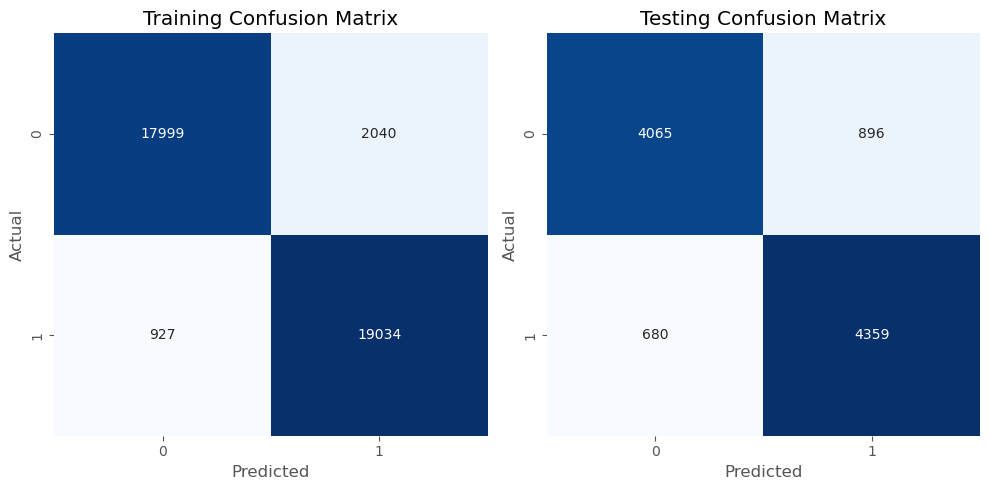

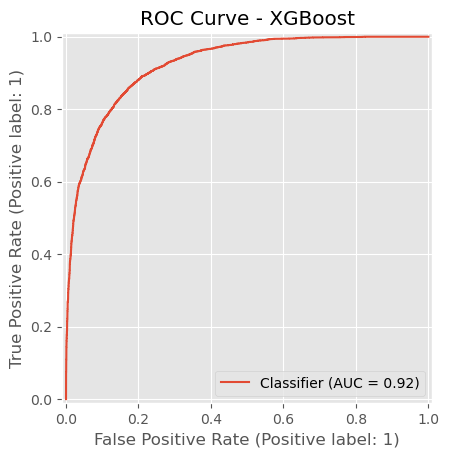

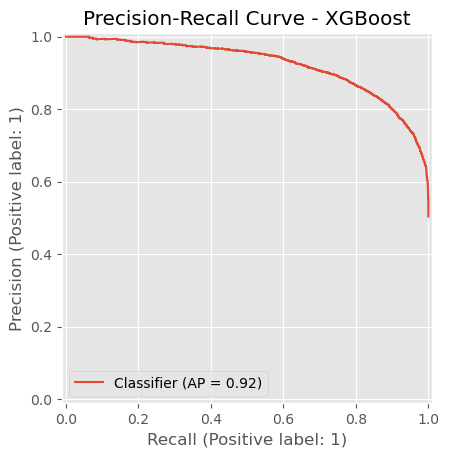

XGBoost Training Performance

Train Accuracy = 0.9258
F1 Score = 0.8469
AUC = 0.9248

XGBoost Testing Performance

Test Accuracy = 0.8424
Test Report = 
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      4961
         1.0       0.83      0.87      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Test Confusion Matrix = 
[[4065  896]
 [ 680 4359]]


In [ ]:
def evaluate_xgboost(X_train, X_test, y_train, y_test, n_estimators=90, learning_rate=0.1, max_depth=10):
    # Set the experiment name 
    mlflow.set_experiment("XGBoost_Experiment")

    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    print("XGBoost Model\n")

    with mlflow.start_run(run_name="XGBoost"):
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("max_depth", max_depth)

        # Fit the model on training data
        model.fit(X_train, y_train)
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC

        # Evaluate the model
        train_report, train_cm, train_accuracy = evaluate_model(y_train, train_pred)
        test_report, test_cm, test_accuracy = evaluate_model(y_test, test_pred)
        f1 = f1_score(y_test, test_pred)  # Calculate F1 score
        auc = roc_auc_score(y_test, test_pred_proba)  # Calculate AUC score

        # Log metrics
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("f1_score", f1)  # Log F1 score
        mlflow.log_metric("auc", auc)  # Log AUC score
        mlflow.log_text(str(train_report), "train_classification_report.txt")
        mlflow.log_text(str(test_report), "test_classification_report.txt")

        # Save the model as an artifact
        model_filename = "xgboost_model.pkl"
        mlflow.xgboost.save_model(model, model_filename)  # Log the model
        mlflow.log_artifact(model_filename)

        # Plot and log confusion matrix
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Training Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Testing Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig("metrics/confusion_matrix_xgboost.png")
        mlflow.log_artifact("metrics/confusion_matrix_xgboost.png")
        plt.show()
        plt.close()

        # Log ROC Curve
        fig_roc = plt.figure()
        RocCurveDisplay.from_predictions(y_test, test_pred_proba, ax=plt.gca())
        plt.title("ROC Curve - XGBoost")
        plt.savefig("metrics/roc_curve_xgboost.png")
        mlflow.log_artifact("metrics/roc_curve_xgboost.png")
        plt.show()
        plt.close()

        # Log Precision-Recall Curve
        fig_pr = plt.figure()
        PrecisionRecallDisplay.from_predictions(y_test, test_pred_proba, ax=plt.gca())
        plt.title("Precision-Recall Curve - XGBoost")
        plt.savefig("metrics/precision_recall_curve_xgboost.png")
        mlflow.log_artifact("metrics/precision_recall_curve_xgboost.png")
        plt.show()
        plt.close()

        # Print results
        print('XGBoost Training Performance\n')
        print(f"Train Accuracy = {train_accuracy:.4f}")
        print(f"F1 Score = {f1:.4f}")
        print(f"AUC = {auc:.4f}")
        print('\nXGBoost Testing Performance\n')
        print(f"Test Accuracy = {test_accuracy:.4f}")
        print(f"Test Report = \n{test_report}")
        print(f"Test Confusion Matrix = \n{test_cm}")

# Execute the evaluation
evaluate_xgboost(X_train_tfidf, X_test_tfidf, y_train, y_test)
